# Imports and Prep

## imports

In [1]:
import json
import requests

import pandas as pd

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 14, 6

import datetime
import dateutil


## functions and variables needed

In [14]:
# unauthenticated requests have lower rate limit - this is why we authenticate
github_user_name = "talagluck"
#TODO: set to your GitHub username
github_oauth_token = ""
#TODO: set to your personal GitHib OAuth token  # get one here: https://github.com/settings/tokens

min_fetch_created_datetime = datetime.datetime.strftime(datetime.datetime.now() + datetime.timedelta(days=-180), "%Y-%m-%d") + "T00:00:00Z"
print(min_fetch_created_datetime)

min_report_created_datetime = datetime.datetime.now() + datetime.timedelta(days=-90)
min_report_created_datetime_str = datetime.datetime.strftime(min_report_created_datetime, "%Y-%m-%d") + "T00:00:00Z"
print(min_report_created_datetime_str)


2021-09-05T00:00:00Z
2021-12-04T00:00:00Z


In [15]:
# issue functions
def send_request_to_github_api(url):
    # We use basic auth with a personal OAuth token: https://developer.github.com/v3/auth/#basic-authentication
    
    headers = {'Accept': 'application/vnd.github.v3+json'
               }
    
    response = requests.get(url,
                            auth=(github_user_name, github_oauth_token),
                            headers=headers)
    
    if response.status_code != 200:
        raise Exception("HTTP Status: {0:s}, Reason: {1:s}".format(str(response.status_code), response.reason))
    
    return response

def sunday_of_the_week_date(dt):
#     sunday_dt = (dt + datetime.timedelta(
#                 days=(6 - dt.weekday()), weeks=-1)).replace(hour=0, minute=0, second=0, microsecond=0)
    if not dt:
        return None
    elif dt.weekday() == 6:
        sunday_dt = dt.replace(hour=0, minute=0, second=0, microsecond=0)
    else:
        sunday_dt = (dt + datetime.timedelta(
                days=(6 - dt.weekday()), weeks=-1)).replace(hour=0, minute=0, second=0, microsecond=0)

    return sunday_dt

def sunday_of_the_week_date_str(dt):
    if not dt:
        return None
    elif dt.weekday() == 6:
        sunday_dt = dt.replace(hour=0, minute=0, second=0, microsecond=0)
    else:
        sunday_dt = (dt + datetime.timedelta(
                days=(6 - dt.weekday()), weeks=-1)).replace(hour=0, minute=0, second=0, microsecond=0)
    return datetime.datetime.strftime(sunday_dt, "%Y-%m-%d")

def get_all_info_for_issue_row(issue_info):
    issue_close_datetime = get_issue_close_datetime(issue_info)
    first_core_team_issue_comment_datetime = get_first_core_team_issue_comment_datetime(issue_info)
    
    return {
        "number": issue_info["number"],
        "author_login": issue_info["user"]["login"],
        "created_dt": issue_info["created_at"],
        "is_core_engineering_queue": has_label_with_name(issue_info, "core-engineering-queue"),
        "is_help_wanted": has_label_with_name(issue_info, "help_wanted"),
        "is_devrel": has_label_with_name(issue_info, "devrel"),
        "is_triage": has_label_with_name(issue_info, "triage"),
        "first_core_team_comment_dt": first_core_team_issue_comment_datetime,
        "close_dt": issue_close_datetime,
        "priority_category": get_issue_category_from_labels(issue_info)
    }
    
def get_issue_close_datetime(issue_info):
    return issue_info["closed_at"]

def has_label_with_name(issue_info, label_name):
    issue_labels = issue_info.get("labels")
    if issue_labels is not None:
        return len([issue_label for issue_label in issue_labels if issue_label["name"] == label_name]) > 0
    return False
    

def get_issue_category_from_labels(issue_info):
    issue_labels = issue_info.get("labels")
    if issue_labels is not None:
        for issue_label in issue_labels:
            if issue_label["name"] == 'core-engineering-queue':
                return 'core-engineering-queue'
            if issue_label["name"] == 'help wanted':
                return 'help wanted'
            if issue_label["name"] == 'devrel':
                return 'devrel'
            if issue_label["name"] == 'triage':
                return 'triage'
            
    return "other"


def get_first_core_team_issue_comment_datetime(issue_info):
    issue_number = issue_info["number"]
    first_core_team_issue_comment_datetime = None
    
    issue_comments_response = send_request_to_github_api("https://api.github.com/repos/great-expectations/great_expectations/issues/{0:d}/comments".format(issue_number))

    core_team_issue_comment_datetimes = sorted([comment["created_at"] for comment in issue_comments_response.json() if comment["user"]["login"] in core_team_usernames])
    
    if len(core_team_issue_comment_datetimes) > 0:
        first_core_team_issue_comment_datetime = core_team_issue_comment_datetimes[0]

    return first_core_team_issue_comment_datetime
    

In [16]:
# PR functions
def get_all_info_for_pr_row(pr_info):
    pr_merge_datetime = get_pr_merge_datetime(pr_info)
    pr_close_datetime = get_pr_close_datetime(pr_info)
    first_core_team_pr_comment_datetime = get_first_core_team_pr_comment_datetime(pr_info)
    first_core_team_pr_review_datetime, first_core_team_approval_datetime = get_first_core_team_pr_review_and_approval_datetimes(pr_info)

    if first_core_team_pr_comment_datetime is not None and first_core_team_pr_review_datetime is not None:
        first_core_team_reaction_datetime = sorted([first_core_team_pr_comment_datetime, first_core_team_pr_review_datetime])[0]
    else: 
        first_core_team_reaction_datetime = first_core_team_pr_comment_datetime or first_core_team_pr_review_datetime
    
    return {
        "number": pr_info["number"],
        "created_dt": pr_info["created_at"],
        "first_core_team_reaction_dt": first_core_team_reaction_datetime,
        "first_core_team_comment_dt": first_core_team_pr_comment_datetime,
        "first_core_team_review_dt": first_core_team_pr_review_datetime,
        "first_core_team_approval_dt": first_core_team_approval_datetime,
        "merge_dt": pr_merge_datetime,
        "close_dt": pr_close_datetime,
    }
    
    
def get_pr_close_datetime(pr_info):
    return pr_info["closed_at"]

def get_pr_merge_datetime(pr_info):
    return pr_info["merged_at"]
    
def get_first_core_team_pr_comment_datetime(pr_info):
    pr_number = pr_info["number"]
    first_core_team_pr_comment_datetime = None
    
    pr_comments_response = send_request_to_github_api("https://api.github.com/repos/great-expectations/great_expectations/issues/{0:d}/comments".format(pr_number))

    core_team_pr_comment_datetimes = sorted([comment["created_at"] for comment in pr_comments_response.json() if comment["user"]["login"] in core_team_usernames])
    
    if len(core_team_pr_comment_datetimes) > 0:
        first_core_team_pr_comment_datetime = core_team_pr_comment_datetimes[0]

    return first_core_team_pr_comment_datetime
    
def get_first_core_team_pr_review_and_approval_datetimes(pr_info):
    pr_number = pr_info["number"]
    first_core_team_pr_review_datetime = None
    first_core_team_pr_approval_datetime = None
    
    pr_reviews_response = send_request_to_github_api("https://api.github.com/repos/great-expectations/great_expectations/pulls/{0:d}/reviews".format(pr_number))
    
    core_team_pr_review_datetimes = sorted([review["submitted_at"] for review in pr_reviews_response.json() if review["user"]["login"] in core_team_usernames])
    if len(core_team_pr_review_datetimes) > 0:
        first_core_team_pr_review_datetime = core_team_pr_review_datetimes[0]

    core_team_pr_approval_datetimes = sorted([review["submitted_at"] for review in pr_reviews_response.json() if review["user"]["login"] in core_team_usernames and review["state"] == "APPROVED"])
    if len(core_team_pr_approval_datetimes) > 0:
        first_core_team_pr_approval_datetime = core_team_pr_approval_datetimes[0]

    return (first_core_team_pr_review_datetime, first_core_team_pr_approval_datetime)
    

    

In [17]:
todays_date = datetime.date.today().strftime("%m_%d_%y")
todays_date

directory_for_graph_save = "/Users/talgluck/Documents/great_expectations_analytics/devrel_metrics/weekly_devrel_stats"

def get_save_graph_file_name(graph_name, todays_date):
    return f"{directory_for_graph_save}/{graph_name}-{todays_date}.png"

## core team list

In [18]:
core_team_usernames = { # these are former team members to filter out. We will additionally add current members of the organization
    'spbail-ge',
    'spbail',
    'Aylr',
    'dependabot[bot]',
    'gilpasternak35',
    'snyk-bot',
    'dependabot'
}

url_sc = "https://api.github.com/orgs/superconductive/members"
url_ge = "https://api.github.com/orgs/great-expectations/members"

for member_organization_url in [url_sc, url_ge]:
    members = send_request_to_github_api(member_organization_url)
    core_team_usernames.update({i.get("login") for i in members.json()})

core_team_usernames

{'AFineDayFor',
 'Aylr',
 'DrewHoo',
 'NathanFarmer',
 'OrtalG',
 'Rachel-Reverie',
 'Shinnnyshinshin',
 'Super-Tanner',
 'Walina03',
 'abegong',
 'alexsherstinsky',
 'allensallinger',
 'anthonyburdi',
 'austiezr',
 'bhcastleton',
 'cdkini',
 'dependabot',
 'dependabot[bot]',
 'donaldheppner',
 'drewmck-superconductive',
 'eimmen',
 'elenajdanova',
 'eugmandel',
 'fjork3',
 'gilpasternak35',
 'jcampbell',
 'joshua-stauffer',
 'kenwade4',
 'kyleaton',
 'lockettks',
 'rdodev',
 'roblim',
 'rreinoldsc',
 'snyk-bot',
 'spbail',
 'spbail-ge',
 'spencerhardwick',
 'talagluck'}

# Contributor Stats

In [19]:
response = requests.get("https://api.github.com/repos/great-expectations/great_expectations/stats/contributors")
response_json = response.json()
response_json

[{'total': 2,
  'weeks': [{'w': 1496534400, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1497139200, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1497744000, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1498348800, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1498953600, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1499558400, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1500163200, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1500768000, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1501372800, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1501977600, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1502582400, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1503187200, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1503792000, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1504396800, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1505001600, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1505606400, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1506211200, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1506816000, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1507420800, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1508025600, 'a': 0, 'd': 0, 'c': 0},
   {'w': 1508630400, 'a': 0, 'd': 0, 'c': 0},
   {'w': 15

In [20]:

contributor_list = []

for contrib in response_json:
    contributor_list.append(contrib["author"])

contributor_list

[{'login': 'NiallRees',
  'id': 23722609,
  'node_id': 'MDQ6VXNlcjIzNzIyNjA5',
  'avatar_url': 'https://avatars.githubusercontent.com/u/23722609?v=4',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/NiallRees',
  'html_url': 'https://github.com/NiallRees',
  'followers_url': 'https://api.github.com/users/NiallRees/followers',
  'following_url': 'https://api.github.com/users/NiallRees/following{/other_user}',
  'gists_url': 'https://api.github.com/users/NiallRees/gists{/gist_id}',
  'starred_url': 'https://api.github.com/users/NiallRees/starred{/owner}{/repo}',
  'subscriptions_url': 'https://api.github.com/users/NiallRees/subscriptions',
  'organizations_url': 'https://api.github.com/users/NiallRees/orgs',
  'repos_url': 'https://api.github.com/users/NiallRees/repos',
  'events_url': 'https://api.github.com/users/NiallRees/events{/privacy}',
  'received_events_url': 'https://api.github.com/users/NiallRees/received_events',
  'type': 'User',
  'site_admin': False},
 {'login'

In [21]:
contributor_df = pd.DataFrame(contributor_list)
contributor_df

,login,id,node_id,avatar_url,gravatar_id,url,html_url,followers_url,following_url,gists_url,starred_url,subscriptions_url,organizations_url,repos_url,events_url,received_events_url,type,site_admin
0,NiallRees,23722609,MDQ6VXNlcjIzNzIyNjA5,https://avatars.githubusercontent.com/u/237226...,,https://api.github.com/users/NiallRees,https://github.com/NiallRees,https://api.github.com/users/NiallRees/followers,https://api.github.com/users/NiallRees/followi...,https://api.github.com/users/NiallRees/gists{/...,https://api.github.com/users/NiallRees/starred...,https://api.github.com/users/NiallRees/subscri...,https://api.github.com/users/NiallRees/orgs,https://api.github.com/users/NiallRees/repos,https://api.github.com/users/NiallRees/events{...,https://api.github.com/users/NiallRees/receive...,User,False
1,kenwade4,95714847,U_kgDOBbR-Hw,https://avatars.githubusercontent.com/u/957148...,,https://api.github.com/users/kenwade4,https://github.com/kenwade4,https://api.github.com/users/kenwade4/followers,https://api.github.com/users/kenwade4/followin...,https://api.github.com/users/kenwade4/gists{/g...,https://api.github.com/users/kenwade4/starred{...,https://api.github.com/users/kenwade4/subscrip...,https://api.github.com/users/kenwade4/orgs,https://api.github.com/users/kenwade4/repos,https://api.github.com/users/kenwade4/events{/...,https://api.github.com/users/kenwade4/received...,User,False
2,miike,1387007,MDQ6VXNlcjEzODcwMDc=,https://avatars.githubusercontent.com/u/138700...,,https://api.github.com/users/miike,https://github.com/miike,https://api.github.com/users/miike/followers,https://api.github.com/users/miike/following{/...,https://api.github.com/users/miike/gists{/gist...,https://api.github.com/users/miike/starred{/ow...,https://api.github.com/users/miike/subscriptions,https://api.github.com/users/miike/orgs,https://api.github.com/users/miike/repos,https://api.github.com/users/miike/events{/pri...,https://api.github.com/users/miike/received_ev...,User,False
3,PSUlion16,24613077,MDQ6VXNlcjI0NjEzMDc3,https://avatars.githubusercontent.com/u/246130...,,https://api.github.com/users/PSUlion16,https://github.com/PSUlion16,https://api.github.com/users/PSUlion16/followers,https://api.github.com/users/PSUlion16/followi...,https://api.github.com/users/PSUlion16/gists{/...,https://api.github.com/users/PSUlion16/starred...,https://api.github.com/users/PSUlion16/subscri...,https://api.github.com/users/PSUlion16/orgs,https://api.github.com/users/PSUlion16/repos,https://api.github.com/users/PSUlion16/events{...,https://api.github.com/users/PSUlion16/receive...,User,False
4,rreinoldsc,85508632,MDQ6VXNlcjg1NTA4NjMy,https://avatars.githubusercontent.com/u/855086...,,https://api.github.com/users/rreinoldsc,https://github.com/rreinoldsc,https://api.github.com/users/rreinoldsc/followers,https://api.github.com/users/rreinoldsc/follow...,https://api.github.com/users/rreinoldsc/gists{...,https://api.github.com/users/rreinoldsc/starre...,https://api.github.com/users/rreinoldsc/subscr...,https://api.github.com/users/rreinoldsc/orgs,https://api.github.com/users/rreinoldsc/repos,https://api.github.com/users/rreinoldsc/events...,https://api.github.com/users/rreinoldsc/receiv...,User,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,donaldheppner,4479894,MDQ6VXNlcjQ0Nzk4OTQ=,https://avatars.githubusercontent.com/u/447989...,,https://api.github.com/users/donaldheppner,https://github.com/donaldheppner,https://api.github.com/users/donaldheppner/fol...,https://api.github.com/users/donaldheppner/fol...,https://api.github.com/users/donaldheppner/gis...,https://api.github.com/users/donaldheppner/sta...,https://api.github.com/users/donaldheppner/sub...,https://api.github.com/users/donaldheppner/orgs,https://api.github.com/users/donaldheppner/repos,https://api.github.com/users/donaldheppner/eve...,https://api.github.com/users/donaldheppner/rec...,User,False
95,dmateusp,8832050,MDQ6VXNlcjg4MzIwNTA=,https://avatars.githubusercontent.com/u

In [22]:
contributor_week_list = []
all_weeks = set()

for contrib in response_json:
    
    first_contrib = True
    for week in contrib["weeks"]:
        week["login"] = contrib["author"]["login"]
        week["contributors"] = 1
    
        if week["c"] > 0:
            week["first_contrib"] = first_contrib
            contributor_week_list.append(week)
            
            #This method of detecting first contributions will only work if week timestamps in "w" are sorted in ascending order
            #This appears to be true, but is untested.
            first_contrib = False
            
        all_weeks.add(week["w"])
        
contributor_week_df = pd.DataFrame(contributor_week_list)
contributor_week_df

,w,a,d,c,login,contributors,first_contrib
0,1601769600,169,23,1,NiallRees,1,True
1,1603584000,0,1,1,NiallRees,1,False
2,1640476800,92,92,1,kenwade4,1,True
3,1643500800,310,310,1,kenwade4,1,False
4,1644105600,27,20,2,kenwade4,1,False
...,...,...,...,...,...,...,...
1055,1523145600,346,47,5,bouke-nederstigt,1,False
1056,1523750400,229,286,3,bouke-nederstigt,1,False
1057,1572739200,1,3,3,williamjr,1,True
1058,1612656000,5,5,1,lukedyer-peak,1,True


In [23]:
filtered_contributor_week_df = contributor_week_df[contributor_week_df.login.isin(core_team_usernames)==False]
filtered_contributor_week_df

,w,a,d,c,login,contributors,first_contrib
0,1601769600,169,23,1,NiallRees,1,True
1,1603584000,0,1,1,NiallRees,1,False
8,1604793600,407,2,1,miike,1,True
9,1612051200,3,3,1,miike,1,False
10,1614470400,2,2,1,miike,1,False
...,...,...,...,...,...,...,...
1055,1523145600,346,47,5,bouke-nederstigt,1,False
1056,1523750400,229,286,3,bouke-nederstigt,1,False
1057,1572739200,1,3,3,williamjr,1,True
1058,1612656000,5,5,1,lukedyer-peak,1,True


In [24]:
week_df = pd.DataFrame({"week_timestamp" : list(all_weeks)})

contributions = filtered_contributor_week_df.groupby("w").sum()["c"].to_frame().reset_index()
contributions.columns = ["week_timestamp", "total_contributions"]
week_df = week_df.merge(contributions, how='left', on="week_timestamp")

contributors = filtered_contributor_week_df.groupby("w").sum()["contributors"].to_frame().reset_index()
contributors.columns = ["week_timestamp", "total_contributors"]
week_df = week_df.merge(contributors, how='left', on="week_timestamp")

contributors = filtered_contributor_week_df.groupby("w").sum()["first_contrib"].to_frame().reset_index()
contributors.columns = ["week_timestamp", "new_contributors"]
week_df = week_df.merge(contributors, how='left', on="week_timestamp")

week_df = week_df.fillna(0)

week_df["week_dates"] = week_df.week_timestamp.map(lambda x: datetime.datetime.fromtimestamp(x))

week_df.head()

,week_timestamp,total_contributions,total_contributors,new_contributors,week_dates
0,1497139200,0.0,0.0,0.0,2017-06-10 20:00:00
1,1499558400,0.0,0.0,0.0,2017-07-08 20:00:00
2,1501977600,0.0,0.0,0.0,2017-08-05 20:00:00
3,1518912000,0.0,0.0,0.0,2018-02-17 19:00:00
4,1506816000,0.0,0.0,0.0,2017-09-30 20:00:00


In [25]:
week_df.tail()

,week_timestamp,total_contributions,total_contributors,new_contributors,week_dates
243,1533427200,0.0,0.0,0.0,2018-08-04 20:00:00
244,1610841600,2.0,1.0,0.0,2021-01-16 19:00:00
245,1570320000,0.0,0.0,0.0,2019-10-05 20:00:00
246,1607212800,0.0,0.0,0.0,2020-12-05 19:00:00
247,1566691200,0.0,0.0,0.0,2019-08-24 20:00:00


In [26]:
week_df.sort_values('week_timestamp', inplace=True)
week_df.week_timestamp[:13]

# plt.plot(week_df.week_timestamp[-13:], week_df.total_contributions[-13:])
# plt.scatter(week_df.week_timestamp[-13:], week_df.total_contributions[-13:])
# plt.xticks(week_df.week_timestamp[-13:], week_df.week_dates[-13:].map(lambda x: str(x)[:11]), rotation=45, ha="right")
# plt.title("Outside contributions (commits) per week")

# plt.savefig("figures/commits_per_week_1q_trailing_"+str(datetime.date.today())+".png")

189    1496534400
0      1497139200
64     1497744000
126    1498348800
190    1498953600
1      1499558400
65     1500163200
127    1500768000
191    1501372800
2      1501977600
72     1502582400
128    1503187200
234    1503792000
Name: week_timestamp, dtype: int64

In [27]:
!pwd

/Users/talgluck/Documents/great_expectations_analytics/devrel_metrics


### Graph

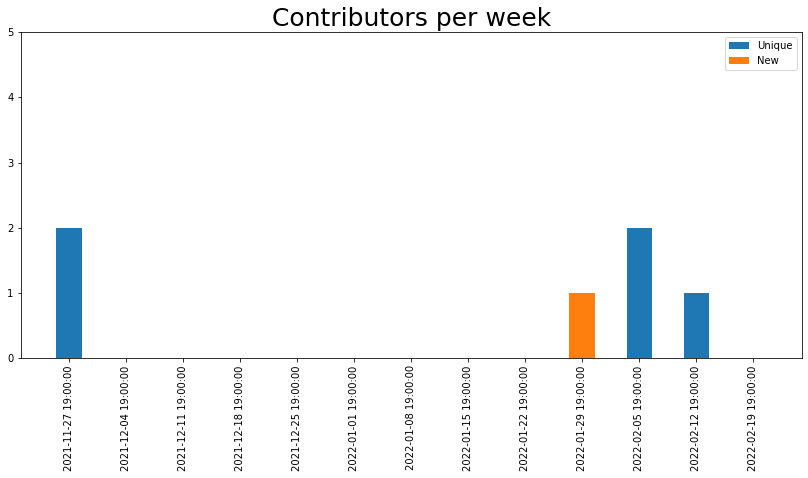

In [28]:
plt.bar(range(-14,-1), week_df.total_contributors[-14:-1], width=0.45)
plt.xticks(range(-14,-1), week_df.week_dates[-14:-1], rotation='vertical')

plt.bar(range(-14,-1), week_df.new_contributors[-14:-1], width=0.45)
plt.xticks(range(-14,-1), week_df.week_dates[-14:-1], rotation='vertical')
plt.yticks(range(0,6))
plt.title('Contributors per week', fontsize=25)

plt.legend(["Unique", "New"])

plt.savefig(get_save_graph_file_name("contributors", todays_date), bbox_inches='tight')

# PR Stats

In [29]:
list_pr_request_url = "https://api.github.com/repos/great-expectations/great_expectations/pulls?state=all&sort=created&direction=desc"
pr_infos = []
# we are using GH API's paging
while list_pr_request_url is not None :
    pr_list_response = send_request_to_github_api(list_pr_request_url)

    pr_infos.extend(pr_list_response.json())

    # response.links has "next" {'url': '...&page=3', 'rel': 'next'}
    next_page_info = pr_list_response.links.get("next")
    if next_page_info is None:
        break
    list_pr_request_url = next_page_info["url"]

    sorted_page_pr_create_datetimes = sorted([pr_info["created_at"] for pr_info in pr_list_response.json()])
    print("Paged response: {0:d} PRs, min created at: {1:s}".format(len(sorted_page_pr_create_datetimes), sorted_page_pr_create_datetimes[0] if len(sorted_page_pr_create_datetimes) > 0 else "")) 
    if len(sorted_page_pr_create_datetimes) > 0 and sorted_page_pr_create_datetimes[0] < min_report_created_datetime_str:
        break

#eligible_pr_infos = [pr_info for pr_info in pr_infos if (pr_info["user"]["login"] not in core_team_usernames and not pr_info["draft"] and pr_info["created_at"] >= min_pr_created_datetime )]
eligible_pr_infos = [pr_info for pr_info in pr_infos if (pr_info["user"]["login"] not in core_team_usernames and not pr_info["draft"] and pr_info["created_at"] >= str(min_report_created_datetime) )]
print("Fetched {0:d} PRs. Out of them {1:d} eligible for the report.".format(len(pr_infos), len(eligible_pr_infos)))
        

Paged response: 30 PRs, min created at: 2022-03-01T08:36:52Z
Paged response: 30 PRs, min created at: 2022-02-23T16:31:09Z
Paged response: 30 PRs, min created at: 2022-02-17T18:27:33Z
Paged response: 30 PRs, min created at: 2022-02-14T16:38:15Z
Paged response: 30 PRs, min created at: 2022-02-08T07:17:09Z
Paged response: 30 PRs, min created at: 2022-02-02T16:54:35Z
Paged response: 30 PRs, min created at: 2022-01-27T19:09:41Z
Paged response: 30 PRs, min created at: 2022-01-21T20:00:32Z
Paged response: 30 PRs, min created at: 2022-01-14T00:20:16Z
Paged response: 30 PRs, min created at: 2022-01-07T17:14:18Z
Paged response: 30 PRs, min created at: 2022-01-03T14:16:11Z
Paged response: 30 PRs, min created at: 2021-12-22T23:24:48Z
Paged response: 30 PRs, min created at: 2021-12-15T19:24:09Z
Paged response: 30 PRs, min created at: 2021-12-08T00:39:19Z
Paged response: 30 PRs, min created at: 2021-12-02T17:27:31Z
Fetched 450 PRs. Out of them 25 eligible for the report.


In [30]:
pr_info_rows = [get_all_info_for_pr_row(pr_info) for pr_info in eligible_pr_infos]

df_prs = pd.DataFrame(pr_info_rows)
df_prs.head()

,number,created_dt,first_core_team_reaction_dt,first_core_team_comment_dt,first_core_team_review_dt,first_core_team_approval_dt,merge_dt,close_dt
0,4301,2022-03-01T06:00:17Z,2022-03-02T19:14:11Z,2022-03-02T19:14:11Z,None,None,None,None
1,4289,2022-02-26T04:59:39Z,2022-02-28T17:19:41Z,None,2022-02-28T17:19:41Z,2022-02-28T17:19:41Z,2022-02-28T17:19:54Z,2022-02-28T17:19:54Z
2,4278,2022-02-25T07:18:02Z,2022-02-28T16:50:04Z,2022-02-28T16:50:28Z,2022-02-28T16:50:04Z,2022-02-28T16:50:04Z,2022-02-28T16:51:14Z,2022-02-28T16:51:14Z
3,4224,2022-02-16T23:42:33Z,2022-02-18T15:46:25Z,None,2022-02-18T15:46:25Z,2022-02-23T16:45:14Z,2022-02-23T17:54:15Z,2022-02-23T17:54:15Z
4,4174,2022-02-10T19:51:31Z,2022-02-18T20:41:26Z,2022-02-18T20:41:26Z,2022-02-25T21:34:58Z,2022-02-25T23:27:05Z,2022-02-25T23:28:12Z,2022-02-25T23:28:12Z


In [31]:
df_prs["week"] = df_prs.apply(lambda x: sunday_of_the_week_date_str(dateutil.parser.parse(x["created_dt"])), axis=1) 
df_prs["week_dt"] = df_prs.apply(lambda x: sunday_of_the_week_date(dateutil.parser.parse(x["created_dt"])), axis=1) 
df_prs = df_prs[(df_prs["close_dt"].isnull()) | (df_prs["merge_dt"].notnull())]

df_prs["created"] = df_prs["created_dt"].notnull().astype(int)
df_prs["first_core_team_reaction"] = df_prs["first_core_team_reaction_dt"].notnull().astype(int)
df_prs["first_core_team_review"] = df_prs["first_core_team_review_dt"].notnull().astype(int)
df_prs["first_core_team_approval"] = df_prs["first_core_team_approval_dt"].notnull().astype(int)
df_prs["merge"] = df_prs["merge_dt"].notnull().astype(int)
df_prs["close"] = df_prs["close_dt"].notnull().astype(int)
df_prs

df_report = df_prs.pivot_table(index=["week"], values=["created", "first_core_team_reaction", "first_core_team_review", "first_core_team_approval", "merge"], aggfunc=[np.sum])
df_report = df_report.reset_index()
df_report.columns = ["week", "created", "approved", "reacted", "reviewed", "merged"]
df_report

,week,created,approved,reacted,reviewed,merged
0,2021-12-05,2,2,2,2,2
1,2021-12-12,1,1,1,1,1
2,2021-12-19,1,1,1,1,0
3,2022-01-02,3,3,3,3,3
4,2022-01-16,2,2,2,2,2
5,2022-02-06,3,2,2,2,2
6,2022-02-13,1,1,1,1,1
7,2022-02-20,2,2,2,2,2
8,2022-02-27,1,0,1,0,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


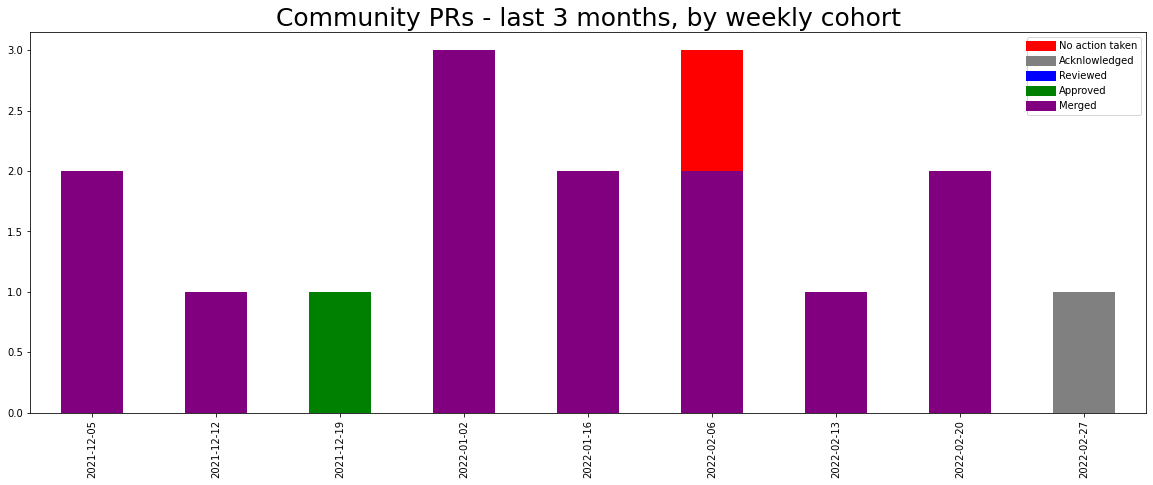

In [32]:
from matplotlib.lines import Line2D
plt.rcParams["figure.figsize"] = (20,7)
_, ax = plt.subplots()
# df_report[df_report["week"]>"2020-09-27"].plot(kind= 'bar', x="week", y=["created", "reacted", "reviewed", "approved", "merged"])
#df_report.plot(kind= 'bar', x="week", y=["created", "reacted", "reviewed", "approved", "merged"])
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
df_report.created.plot(kind='bar', ax=ax, color='red')
df_report.reacted.plot(kind='bar', ax=ax, color='grey')
df_report.reviewed.plot(kind='bar', ax=ax, color='blue')
df_report.approved.plot(kind='bar', ax=ax, color='green')
df_report.merged.plot(kind='bar', ax=ax, color='purple')
ax.set_xticks(df_report.index)
ax.set_xticklabels(df_report["week"].values)
cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color="red", lw=10),
                Line2D([0], [0], color="grey", lw=10),
                Line2D([0], [0], color="blue", lw=10),
                Line2D([0], [0], color="green", lw=10),
                Line2D([0], [0], color="purple", lw=10),
               ]
ax.legend(custom_lines, ['No action taken', 'Acknlowledged', 'Reviewed', 'Approved', 'Merged'])
plt.title("Community PRs - last 3 months, by weekly cohort", fontsize=25)
plt.savefig(get_save_graph_file_name("prs-by-cohort", todays_date), bbox_inches='tight')

In [33]:
def pr_is_open_during_week(week_dt, x):
    week_end_dt = week_dt+datetime.timedelta(days = 7)
    created_dt = dateutil.parser.parse(x["created_dt"])
    close_dt = None
    if not pd.isnull(x["close_dt"]):
        close_dt = dateutil.parser.parse(x["close_dt"])
    
    return created_dt < week_end_dt and (pd.isnull(close_dt) or close_dt > week_end_dt)
    

# This is a not a Pandas way to do it, but gets the job done. Would be lovely to find out an elegant way to do this.    
week_open_pr_counts = []    
for week_dt_ref in df_prs["week_dt"].unique():
    s_tmp = df_prs.apply(lambda x: pr_is_open_during_week(week_dt_ref, x), axis=1)
    week_open_pr_counts.append({
        "week_dt": week_dt_ref,
        "count": s_tmp[s_tmp == True].shape[0]
    })

df_num_open_community_prs_weekly = pd.DataFrame(week_open_pr_counts).sort_values("week_dt")
df_num_open_community_prs_weekly["week"] = df_num_open_community_prs_weekly["week_dt"].apply(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"))
pd.DataFrame(week_open_pr_counts)

,week_dt,count
0,2022-02-27 00:00:00+00:00,3
1,2022-02-20 00:00:00+00:00,4
2,2022-02-13 00:00:00+00:00,4
3,2022-02-06 00:00:00+00:00,3
4,2022-01-16 00:00:00+00:00,4
5,2022-01-02 00:00:00+00:00,4
6,2021-12-19 00:00:00+00:00,2
7,2021-12-12 00:00:00+00:00,1
8,2021-12-05 00:00:00+00:00,2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


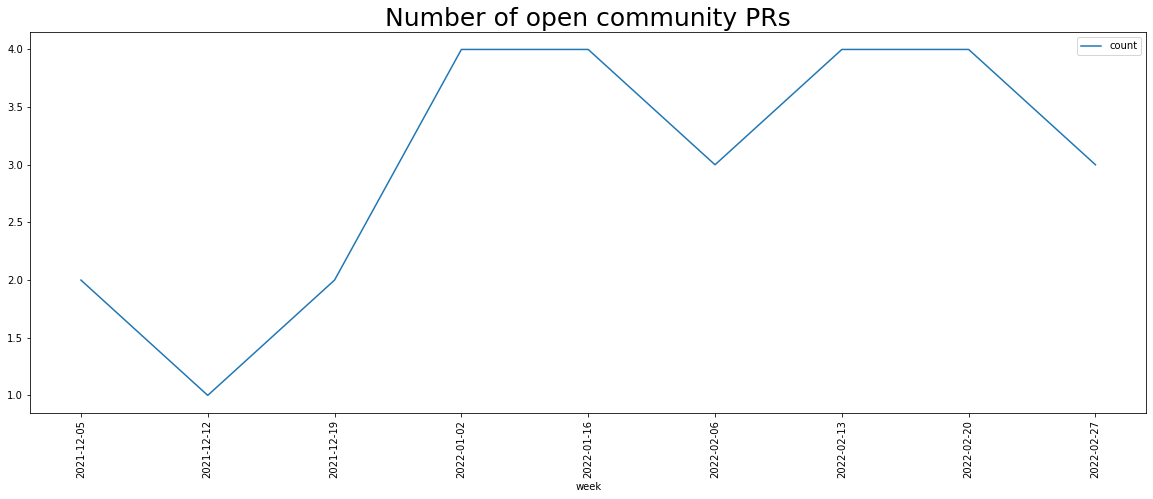

In [34]:
from matplotlib.lines import Line2D
plt.rcParams["figure.figsize"] = (20,7)
_, ax = plt.subplots()
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
df_num_open_community_prs_weekly.plot(kind='line', ax=ax, x="week", y="count", rot=90)
ax.set_xticks(df_report.index)
ax.set_xticklabels(df_num_open_community_prs_weekly["week"].values)
cmap = plt.cm.coolwarm
plt.title('Number of open community PRs', fontsize=25)
plt.savefig(get_save_graph_file_name("open-prs", todays_date), bbox_inches='tight')

In [35]:
# identify the week a PR was created, merged, and closed if not merged
pr_burn_date_df = pd.DataFrame(pr_info_rows)
pr_burn_date_df = pr_burn_date_df[["created_dt", "merge_dt", "close_dt"]]
pr_burn_date_df["created_this_week"] = pr_burn_date_df.apply(lambda x: sunday_of_the_week_date_str(dateutil.parser.parse(x["created_dt"])), axis=1)
pr_burn_date_df["merged_this_week"] = pr_burn_date_df.apply(lambda x: sunday_of_the_week_date_str(dateutil.parser.parse(x["merge_dt"]) if x["merge_dt"] is not None else None), axis=1)
pr_burn_date_df["closed_this_week"] = pr_burn_date_df.apply(lambda x: sunday_of_the_week_date_str(dateutil.parser.parse(x["close_dt"]) if x["close_dt"] is not None else None), axis=1)
pr_burn_date_df = pr_burn_date_df[["created_this_week", "merged_this_week", "closed_this_week"]]
pr_burn_date_df["closed_no_merge_this_week"] = np.where(pr_burn_date_df["merged_this_week"].isnull() & pr_burn_date_df["closed_this_week"].notnull(), pr_burn_date_df["closed_this_week"], None)

# count each category out
all_date_values = pr_burn_date_df.values.ravel()
unique_dates = pd.unique(all_date_values)
unique_dates = np.sort(unique_dates[unique_dates != np.array(None)])
pr_burn_df = pd.DataFrame(data=unique_dates, columns=["week"])
created_count = pr_burn_date_df["created_this_week"].value_counts()
merged_count = pr_burn_date_df["merged_this_week"].value_counts()
closed_no_merge_count = pr_burn_date_df["closed_no_merge_this_week"].value_counts()
pr_burn_df = pr_burn_df.merge(created_count, how="outer", left_on="week", right_index=True)
pr_burn_df = pr_burn_df.merge(merged_count, how="outer", left_on="week", right_index=True)
pr_burn_df = pr_burn_df.merge(closed_no_merge_count, how="outer", left_on="week", right_index=True)
pr_burn_df = pr_burn_df.fillna(0)
pr_burn_df["merged_or_closed_this_week"] = pr_burn_df["merged_this_week"] + pr_burn_df["closed_no_merge_this_week"]

# calculate cumulative open PRs
open_prs_start_of_first_week = 21
pr_burn_df["change_in_open_prs"] = pr_burn_df["created_this_week"] - pr_burn_df["merged_or_closed_this_week"]
pr_burn_df["cumulative_open_prs"] = pr_burn_df["change_in_open_prs"].cumsum()
pr_burn_df["cumulative_open_prs"] = pr_burn_df["cumulative_open_prs"] + open_prs_start_of_first_week
pr_burn_df = pr_burn_df.iloc[-13:]
pr_burn_df

,week,created_this_week,merged_this_week,closed_no_merge_this_week,merged_or_closed_this_week,change_in_open_prs,cumulative_open_prs
0,2021-12-05,4.0,0.0,1.0,1.0,3.0,24.0
1,2021-12-12,2.0,2.0,0.0,2.0,0.0,24.0
2,2021-12-19,3.0,0.0,2.0,2.0,1.0,25.0
3,2021-12-26,0.0,1.0,0.0,1.0,-1.0,24.0
4,2022-01-02,3.0,0.0,1.0,1.0,2.0,26.0
5,2022-01-09,1.0,2.0,0.0,2.0,-1.0,25.0
6,2022-01-16,2.0,0.0,1.0,1.0,1.0,26.0
7,2022-01-23,1.0,0.0,1.0,1.0,0.0,26.0
8,2022-01-30,2.0,2.0,1.0,3.0,-1.0,25.0
9,2022-02-06,3.0,2.0,1.0,3.0,0.0,25.0


/usr/local/anaconda3/envs/ge_dev/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/envs/ge_dev/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


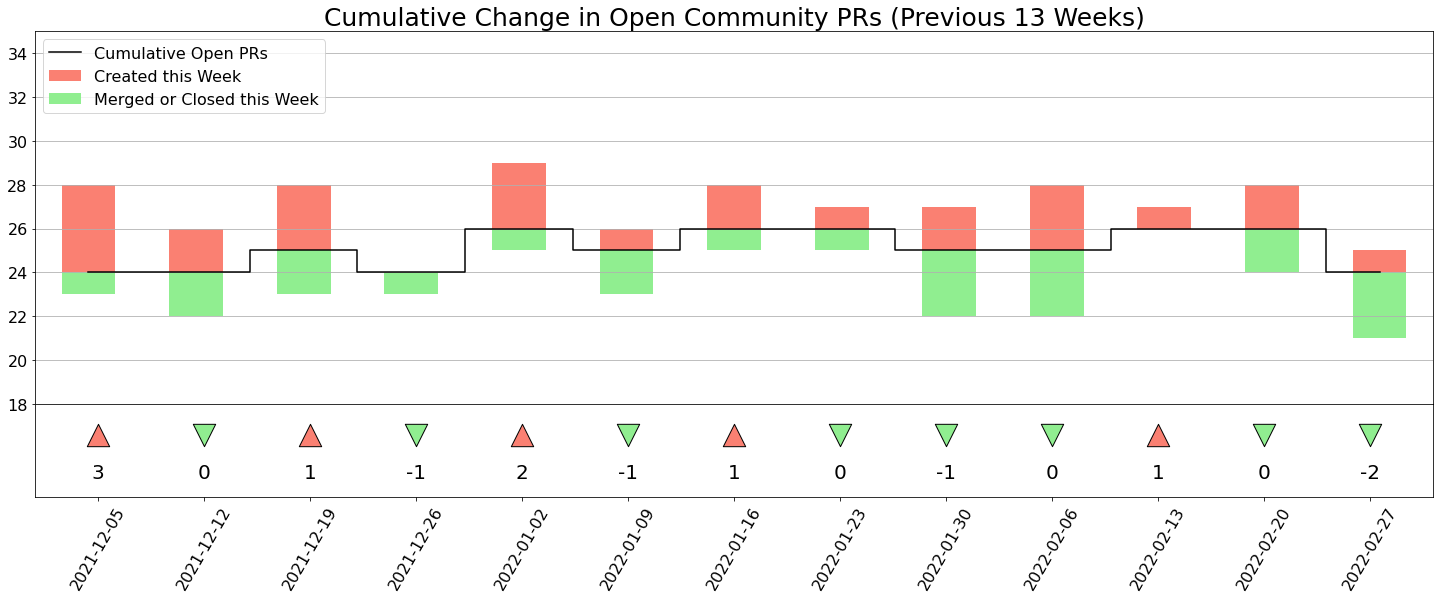

In [36]:
# dataframe just for plot
pr_plot_df = pr_burn_df[["week", "created_this_week", "merged_or_closed_this_week", "change_in_open_prs", "cumulative_open_prs"]]
pr_plot_df["merged_or_closed_this_week"] = pr_plot_df["merged_or_closed_this_week"] * -1
column_names = ["Week", "Created this Week", "Merged or Closed this Week", "Change in Open PRs", "Cumulative Open PRs"]
pr_plot_df.columns = column_names

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [4, 1]})

pr_plot_df.plot(x="Week", y="Cumulative Open PRs", kind="line", ax=ax1, drawstyle='steps-mid', color="black")
pr_plot_df.plot(x="Week", y="Created this Week", kind="bar", ax=ax1, color="salmon", bottom=pr_plot_df["Cumulative Open PRs"])
pr_plot_df.plot(x="Week", y="Merged or Closed this Week", kind="bar", ax=ax1, color="lightgreen", bottom=pr_plot_df["Cumulative Open PRs"])
pr_plot_df["min"] = pr_plot_df["Cumulative Open PRs"] + pr_plot_df["Merged or Closed this Week"]
pr_plot_df["max"] = pr_plot_df["Cumulative Open PRs"] + pr_plot_df["Created this Week"]
ax1.set_ylim([pr_plot_df["min"].min()-3, pr_plot_df["max"].max()+6])
pr_plot_df = pr_plot_df.drop(axis=1, columns=["max", "min"])
ax1.get_xaxis().set_visible(False)

change_colors = np.where(pr_plot_df["Change in Open PRs"] <= 0, "lightgreen", "salmon")
markers = np.where(pr_plot_df["Change in Open PRs"] <= 0, "v", "^")

pr_plot_df["dummy"] = [5] * len(pr_plot_df)
for i in range(len(pr_plot_df)):
    ax2.set_ylim([-5,10])
    ax2.scatter(x=pr_plot_df["Week"].iloc[i], y=pr_plot_df["dummy"].iloc[i], marker=markers[i], color=change_colors[i], s=500, edgecolors="black")
    ax2.annotate(text=pr_plot_df["Change in Open PRs"].iloc[i].astype(int), xy=(pr_plot_df["Week"].iloc[i], -2), ha="center", fontsize=20)
pr_plot_df = pr_plot_df.drop(axis=1, columns=["dummy"])
ax2.get_yaxis().set_visible(False)

fig.tight_layout()
ax1.grid(visible=True, axis="y")
ax1.tick_params(axis="y", which="major", labelsize=16)
ax1.legend(loc=2, fontsize=16)
ax1.set_title('Cumulative Change in Open Community PRs (Previous 13 Weeks)', fontdict={'fontsize': 25})
ax2.tick_params(axis="x", which="major", labelsize=16, rotation=60)
plt.subplots_adjust(hspace=0)
plt.savefig(get_save_graph_file_name("change-open-prs", todays_date), bbox_inches='tight')

# Issue Stats

In [37]:
list_issues_request_url = "https://api.github.com/repos/great-expectations/great_expectations/issues?state=all&sort=created&direction=desc"
issue_infos = []
# we are using GH API's paging
while list_issues_request_url is not None :
    issue_list_response = send_request_to_github_api(list_issues_request_url)

    issue_infos.extend(issue_list_response.json())

    # response.links has "next" {'url': '...&page=3', 'rel': 'next'}
    next_page_info = issue_list_response.links.get("next")
    if next_page_info is None:
        break
    list_issues_request_url = next_page_info["url"]

    sorted_page_pr_create_datetimes = sorted([pr_info["created_at"] for pr_info in issue_list_response.json()])
    print("Paged response: {0:d} issues, min created at: {1:s}".format(len(sorted_page_pr_create_datetimes), sorted_page_pr_create_datetimes[0] if len(sorted_page_pr_create_datetimes) > 0 else "")) 
    if len(sorted_page_pr_create_datetimes) > 0 and sorted_page_pr_create_datetimes[0] < min_fetch_created_datetime:
        break

eligible_issue_infos = [issue_info for issue_info in issue_infos if (not issue_info.get("pull_request") and issue_info["created_at"] >= min_fetch_created_datetime )]
print("Fetched {0:d} issues. Out of them {1:d} eligible for the report.".format(len(issue_infos), len(eligible_issue_infos)))
        

Paged response: 30 issues, min created at: 2022-03-01T16:59:56Z
Paged response: 30 issues, min created at: 2022-02-24T16:22:43Z
Paged response: 30 issues, min created at: 2022-02-21T16:02:32Z
Paged response: 30 issues, min created at: 2022-02-15T22:05:10Z
Paged response: 30 issues, min created at: 2022-02-10T23:33:24Z
Paged response: 30 issues, min created at: 2022-02-08T07:17:09Z
Paged response: 30 issues, min created at: 2022-02-03T14:52:52Z
Paged response: 30 issues, min created at: 2022-01-28T15:18:35Z
Paged response: 30 issues, min created at: 2022-01-25T17:11:58Z
Paged response: 30 issues, min created at: 2022-01-20T10:37:10Z
Paged response: 30 issues, min created at: 2022-01-13T22:44:08Z
Paged response: 30 issues, min created at: 2022-01-07T17:46:50Z
Paged response: 30 issues, min created at: 2022-01-03T22:02:13Z
Paged response: 30 issues, min created at: 2021-12-26T05:24:25Z
Paged response: 30 issues, min created at: 2021-12-17T02:46:56Z
Paged response: 30 issues, min created a

In [38]:
issue_info_rows = [get_all_info_for_issue_row(issue_info) for issue_info in eligible_issue_infos]
df_issues = pd.DataFrame(issue_info_rows)
df_issues.head()

,number,author_login,created_dt,is_core_engineering_queue,is_help_wanted,is_devrel,is_triage,first_core_team_comment_dt,close_dt,priority_category
0,4324,ejohnson-amerilife,2022-03-03T18:49:15Z,False,False,False,False,None,None,other
1,4323,nazarsh,2022-03-03T16:45:12Z,False,False,True,False,2022-03-03T17:03:56Z,None,devrel
2,4305,akerone,2022-03-01T15:11:16Z,False,False,True,False,2022-03-02T19:35:08Z,None,devrel
3,4303,80auline,2022-03-01T14:13:19Z,False,False,True,False,2022-03-02T19:32:44Z,None,devrel
4,4296,cameronezell,2022-02-28T21:15:18Z,False,False,True,False,2022-03-02T19:21:40Z,None,devrel


In [39]:
df_issues["week"] = df_issues.apply(lambda x: sunday_of_the_week_date_str(dateutil.parser.parse(x["created_dt"])), axis=1) 
df_issues["week_dt"] = df_issues.apply(lambda x: sunday_of_the_week_date(dateutil.parser.parse(x["created_dt"])), axis=1) 
df_issues.head()

,number,author_login,created_dt,is_core_engineering_queue,is_help_wanted,is_devrel,is_triage,first_core_team_comment_dt,close_dt,priority_category,week,week_dt
0,4324,ejohnson-amerilife,2022-03-03T18:49:15Z,False,False,False,False,None,None,other,2022-02-27,2022-02-27 00:00:00+00:00
1,4323,nazarsh,2022-03-03T16:45:12Z,False,False,True,False,2022-03-03T17:03:56Z,None,devrel,2022-02-27,2022-02-27 00:00:00+00:00
2,4305,akerone,2022-03-01T15:11:16Z,False,False,True,False,2022-03-02T19:35:08Z,None,devrel,2022-02-27,2022-02-27 00:00:00+00:00
3,4303,80auline,2022-03-01T14:13:19Z,False,False,True,False,2022-03-02T19:32:44Z,None,devrel,2022-02-27,2022-02-27 00:00:00+00:00
4,4296,cameronezell,2022-02-28T21:15:18Z,False,False,True,False,2022-03-02T19:21:40Z,None,devrel,2022-02-27,2022-02-27 00:00:00+00:00


In [40]:
df_issues["created"] = df_issues["created_dt"].notnull().astype(int)
df_issues["first_core_team_comment"] = (df_issues["first_core_team_comment_dt"].notnull() | df_issues["close_dt"].notnull()).astype(int)
df_issues["close"] = df_issues["close_dt"].notnull().astype(int)

df_community_reported_issues = df_issues[df_issues.apply(lambda x: x["author_login"] not in core_team_usernames, axis=1)] 
print("all issues", df_issues.shape)
print("community issues", df_community_reported_issues.shape)

all issues (242, 15)
community issues (225, 15)


In [41]:
df_report = df_community_reported_issues[df_community_reported_issues["created_dt"] > min_report_created_datetime_str].pivot_table(index=["week"], values=["created", "first_core_team_comment", "close"], aggfunc=[np.sum])
df_report = df_report.reset_index()
df_report.columns = ["week", "closed", "created", "responded"]
df_report.head()

,week,closed,created,responded
0,2021-11-28,1,1,1
1,2021-12-05,8,12,12
2,2021-12-12,5,10,10
3,2021-12-19,4,6,6
4,2021-12-26,1,2,2


In [42]:
df_report = df_report[:13]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


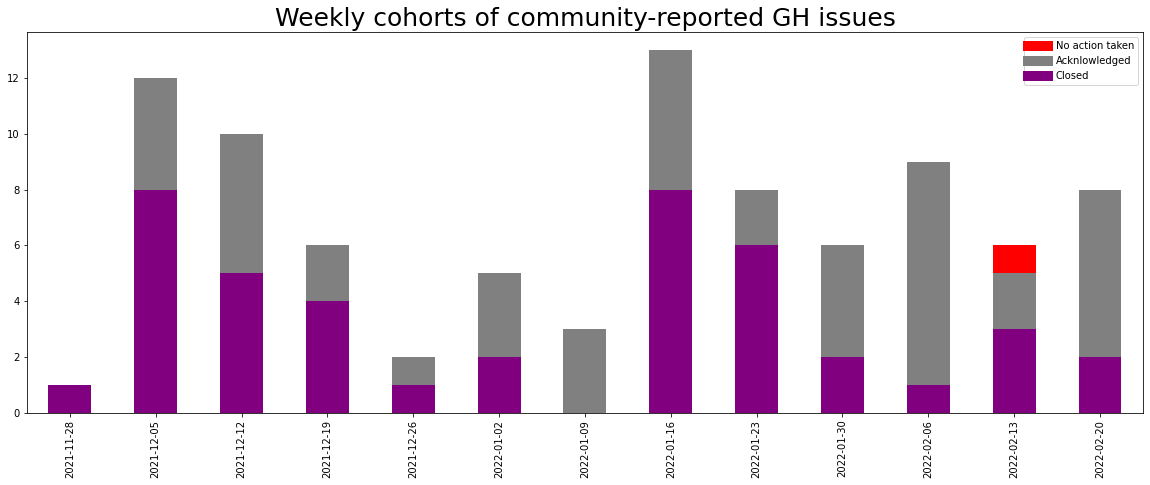

In [43]:
from matplotlib.lines import Line2D
#plt.rcParams.update({'axes.titlesize': 'small'})
plt.rcParams["figure.figsize"] = (20,7)
_, ax = plt.subplots()
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
df_report.created.plot(kind='bar', ax=ax, color='red')
df_report.responded.plot(kind='bar', ax=ax, color='grey')
df_report.closed.plot(kind='bar', ax=ax, color='purple')
ax.set_xticks(df_report.index)
ax.set_xticklabels(df_report["week"].values)
cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color="red", lw=10),
                Line2D([0], [0], color="grey", lw=10),
                Line2D([0], [0], color="purple", lw=10)]
ax.legend(custom_lines, ['No action taken', 'Acknlowledged', 'Closed'])
plt.title('Weekly cohorts of community-reported GH issues', fontsize=25)
plt.savefig(get_save_graph_file_name("issues-by-cohort", todays_date), bbox_inches='tight')

In [44]:
df_issues["week_dt"].unique()
def issue_is_open_during_week(week_dt, x, column_tag: str):
    week_end_dt = week_dt+datetime.timedelta(days = 7)
    created_dt = dateutil.parser.parse(x["created_dt"])
    close_dt = None
    if not pd.isnull(x["close_dt"]):
        close_dt = dateutil.parser.parse(x["close_dt"])
    
    return x[column_tag] and created_dt < week_end_dt and (pd.isnull(close_dt) or close_dt > week_end_dt)
    

# This is a not a Pandas way to do it, but gets the job done. Would be lovely to find out an elegant way to do this.
week_open_issue_counts = []    
for week_dt_ref in df_issues[df_issues["created_dt"] > min_report_created_datetime_str]["week_dt"].unique():
    devrel_count = df_issues.apply(lambda x: issue_is_open_during_week(week_dt_ref, x, "is_devrel"), axis=1)
    core_engineering_queue_count = df_issues.apply(lambda x: issue_is_open_during_week(week_dt_ref, x, "is_core_engineering_queue"), axis=1)
    help_wanted_count = df_issues.apply(lambda x: issue_is_open_during_week(week_dt_ref, x, "is_help_wanted"), axis=1)
    triage_count = df_issues.apply(lambda x: issue_is_open_during_week(week_dt_ref, x, "is_triage"), axis=1)
    
    week_open_issue_counts.append({
        "week_dt": week_dt_ref,
        "devrel_count": devrel_count[devrel_count == True].shape[0],
        "core_engineering_queue_count": core_engineering_queue_count[core_engineering_queue_count == True].shape[0],
        "help_wanted_count": help_wanted_count[help_wanted_count == True].shape[0],
        "triage_count": triage_count[triage_count == True].shape[0], 
    })

df_num_open_core_team_priority_issues_weekly = pd.DataFrame(week_open_issue_counts).sort_values("week_dt")
df_num_open_core_team_priority_issues_weekly["week"] = df_num_open_core_team_priority_issues_weekly["week_dt"].apply(lambda x: datetime.datetime.strftime(x, "%Y-%m-%d"))
df_num_open_core_team_priority_issues_weekly

,week_dt,devrel_count,core_engineering_queue_count,help_wanted_count,triage_count,week
13,2021-11-28 00:00:00+00:00,43,7,0,3,2021-11-28
12,2021-12-05 00:00:00+00:00,48,6,0,4,2021-12-05
11,2021-12-12 00:00:00+00:00,50,6,0,4,2021-12-12
10,2021-12-19 00:00:00+00:00,55,7,0,4,2021-12-19
9,2021-12-26 00:00:00+00:00,49,7,0,4,2021-12-26
8,2022-01-02 00:00:00+00:00,48,7,0,4,2022-01-02
7,2022-01-09 00:00:00+00:00,45,7,0,4,2022-01-09
6,2022-01-16 00:00:00+00:00,44,7,0,9,2022-01-16
5,2022-01-23 00:00:00+00:00,43,8,0,10,2022-01-23
4,2022-01-30 00:00:00+00:00,43,8,0,10,2022-01-30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


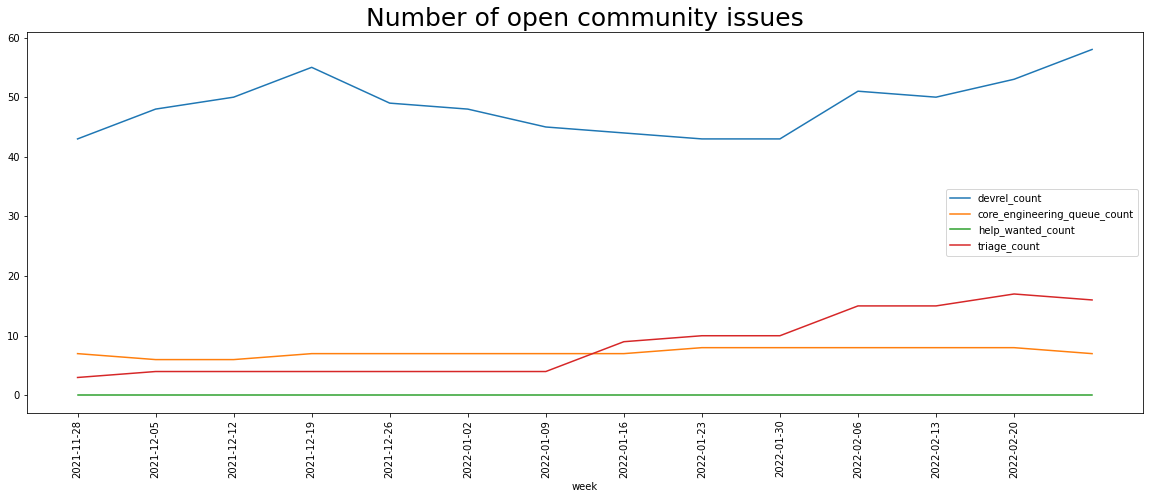

In [45]:
from matplotlib.lines import Line2D
plt.rcParams["figure.figsize"] = (20,7)
_, ax = plt.subplots()
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

for label in [
    "devrel_count",
    "core_engineering_queue_count",
    "help_wanted_count",
    "triage_count"
]:
    df_num_open_core_team_priority_issues_weekly.plot(kind='line', ax=ax, x="week", y=label, rot=90)

ax.set_xticks(df_report.index)
ax.set_xticklabels(df_num_open_core_team_priority_issues_weekly["week"][:13].values)
cmap = plt.cm.coolwarm
plt.title('Number of open community issues', fontsize=25)
plt.savefig(get_save_graph_file_name("open-issues", todays_date), bbox_inches='tight')

In [46]:
# identify the week an issue was created, merged, and closed if not merged
issue_burn_date_df = pd.DataFrame(issue_info_rows)
issue_burn_date_df = issue_burn_date_df[["created_dt", "close_dt"]]
issue_burn_date_df["created_this_week"] = issue_burn_date_df.apply(lambda x: sunday_of_the_week_date_str(dateutil.parser.parse(x["created_dt"])), axis=1)
issue_burn_date_df["closed_this_week"] = issue_burn_date_df.apply(lambda x: sunday_of_the_week_date_str(dateutil.parser.parse(x["close_dt"]) if x["close_dt"] is not None else None), axis=1)
issue_burn_date_df = issue_burn_date_df[["created_this_week", "closed_this_week"]]

# count each category out
all_date_values = issue_burn_date_df.values.ravel()
unique_dates = pd.unique(all_date_values)
unique_dates = np.sort(unique_dates[unique_dates != np.array(None)])
issue_burn_df = pd.DataFrame(data=unique_dates, columns=["week"])
created_count = issue_burn_date_df["created_this_week"].value_counts()
closed_count = issue_burn_date_df["closed_this_week"].value_counts()
issue_burn_df = issue_burn_df.merge(created_count, how="outer", left_on="week", right_index=True)
issue_burn_df = issue_burn_df.merge(closed_count, how="outer", left_on="week", right_index=True)
issue_burn_df = issue_burn_df.fillna(0)

# calculate cumulative open issues
open_issues_start_of_first_week = 1
issue_burn_df["change_in_open_issues"] = issue_burn_df["created_this_week"] - issue_burn_df["closed_this_week"]
issue_burn_df["cumulative_open_issues"] = issue_burn_df["change_in_open_issues"].cumsum()
issue_burn_df["cumulative_open_issues"] = issue_burn_df["cumulative_open_issues"] + open_issues_start_of_first_week
issue_burn_df = issue_burn_df.iloc[-13:]
issue_burn_df

,week,created_this_week,closed_this_week,change_in_open_issues,cumulative_open_issues
13,2021-12-05,12,7.0,5.0,73.0
14,2021-12-12,10,6.0,4.0,77.0
15,2021-12-19,6,1.0,5.0,82.0
16,2021-12-26,2,8.0,-6.0,76.0
17,2022-01-02,5,5.0,0.0,76.0
18,2022-01-09,3,4.0,-1.0,75.0
19,2022-01-16,13,3.0,10.0,85.0
20,2022-01-23,9,8.0,1.0,86.0
21,2022-01-30,6,7.0,-1.0,85.0
22,2022-02-06,10,5.0,5.0,90.0


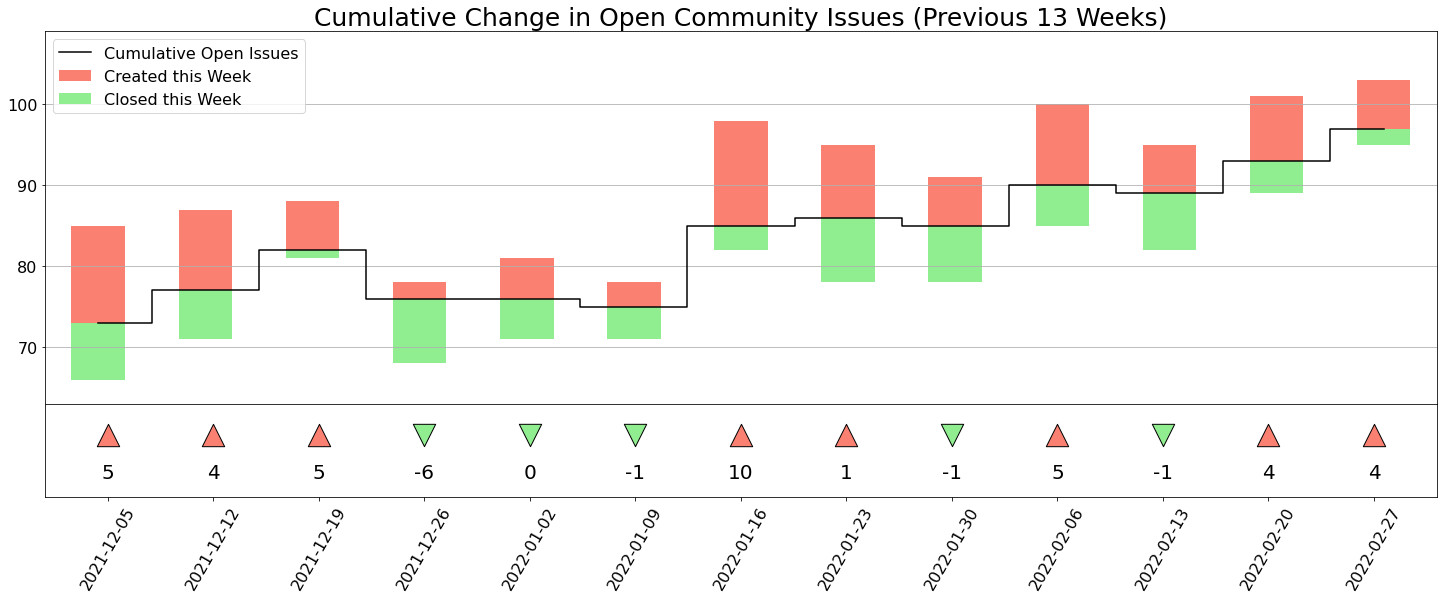

In [47]:
# dataframe just for plot
issue_plot_df = issue_burn_df[["week", "created_this_week", "closed_this_week", "change_in_open_issues", "cumulative_open_issues"]]
issue_plot_df["closed_this_week"] = issue_plot_df["closed_this_week"] * -1
column_names = ["Week", "Created this Week", "Closed this Week", "Change in Open Issues", "Cumulative Open Issues"]
issue_plot_df.columns = column_names

# plot
fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [4, 1]})

issue_plot_df.plot(x="Week", y="Cumulative Open Issues", kind="line", ax=ax1, drawstyle='steps-mid', color="black")
issue_plot_df.plot(x="Week", y="Created this Week", kind="bar", ax=ax1, color="salmon", bottom=issue_plot_df["Cumulative Open Issues"])
issue_plot_df.plot(x="Week", y="Closed this Week", kind="bar", ax=ax1, color="lightgreen", bottom=issue_plot_df["Cumulative Open Issues"])
issue_plot_df["min"] = issue_plot_df["Cumulative Open Issues"] + issue_plot_df["Closed this Week"]
issue_plot_df["max"] = issue_plot_df["Cumulative Open Issues"] + issue_plot_df["Created this Week"]
ax1.set_ylim([issue_plot_df["min"].min()-3, issue_plot_df["max"].max()+6])
issue_plot_df = issue_plot_df.drop(axis=1, columns=["max", "min"])
ax1.get_xaxis().set_visible(False)

change_colors = np.where(issue_plot_df["Change in Open Issues"] <= 0, "lightgreen", "salmon")
markers = np.where(issue_plot_df["Change in Open Issues"] <= 0, "v", "^")

issue_plot_df["dummy"] = [5] * len(issue_plot_df)
for i in range(len(issue_plot_df)):
    ax2.set_ylim([-5,10])
    ax2.scatter(x=issue_plot_df["Week"].iloc[i], y=issue_plot_df["dummy"].iloc[i], marker=markers[i], color=change_colors[i], s=500, edgecolors="black")
    ax2.annotate(text=issue_plot_df["Change in Open Issues"].iloc[i].astype(int), xy=(issue_plot_df["Week"].iloc[i], -2), ha="center", fontsize=20)
issue_plot_df = issue_plot_df.drop(axis=1, columns=["dummy"])
ax2.get_yaxis().set_visible(False)

fig.tight_layout()
ax1.grid(visible=True, axis="y")
ax1.tick_params(axis="y", which="major", labelsize=16)
ax1.legend(loc=2, fontsize=16)
ax1.set_title('Cumulative Change in Open Community Issues (Previous 13 Weeks)', fontdict={'fontsize': 25})
ax2.tick_params(axis="x", which="major", labelsize=16, rotation=60)
plt.subplots_adjust(hspace=0)
plt.savefig(get_save_graph_file_name("change-open-issues", todays_date), bbox_inches='tight')

In [50]:
df_recent_issue_priority_categories = pd.DataFrame(df_issues[df_issues["week"] > min_report_created_datetime_str].groupby("priority_category")["number"].count())#.reset_index()
df_recent_issue_priority_categories.columns = ["count"]
df_recent_issue_priority_categories

,count
priority_category,
core-engineering-queue,2
devrel,50
help wanted,9
other,17
triage,18


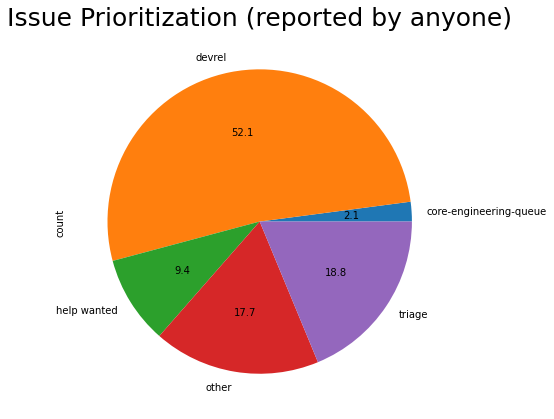

In [51]:
ax = df_recent_issue_priority_categories.plot(kind="pie",  y="count", autopct='%.1f')
plt.title('Issue Prioritization (reported by anyone)', fontsize=25)

ax.get_legend().remove()
plt.savefig(get_save_graph_file_name("issue-prioritization", todays_date), bbox_inches='tight')